In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import torch
import math
from UnarySim.sw.kernel.exp_comb import exp_combinational
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math

In [27]:
def exp_comb_test(bw,mode="unipolar"):
    
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    rng = "Sobol"
    col = 10000
    bitwidth = bw
    bstype = torch.int8
    rtype=torch.float
    stype=torch.int8

    if mode is "unipolar":
        iVec = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    elif mode is "bipolar":
        iVec = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_exp_comb = exp_combinational(bitwidth,mode,rng,1,rtype,stype).to(device)
    
    oVec = torch.exp(iVec.mul(-1)).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    oVecPE = ProgressiveError(oVec, mode=mode).to(device)

    iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
    iVecRNG = RNG(bitwidth, 1, rng)().to(device)
    iVecBS = BSGen(iVecSource, iVecRNG, bstype).to(device)
    
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            iBS = iVecBS(torch.tensor([i]))
            oVecU = dut_exp_comb(iBS)   
            oVecPE.Monitor(oVecU)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
        result_pe = oVecPE()[1].cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("bias", sum(result_pe)/len(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()

--- 0.01197957992553711 seconds ---
output error:  tensor(-2.1875) tensor(-1.8750)
RMSE 2.0229597167578497
bias -2.02054375


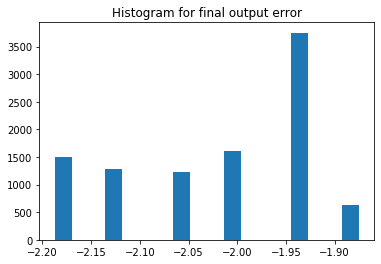

In [28]:
exp_comb_test(4, "unipolar")